In [1]:
from src.data.exercise_data import ExerciseDataset
import numpy as np
import torch
import pandas as pd
import torch.nn as nn
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split

# Load the data
X = np.load(r'C:\Users\barrt\PycharmProjects\Gymalyze\src\data\landmarks_data.npy', allow_pickle=True)
y = np.load(r'C:\Users\barrt\PycharmProjects\Gymalyze\src\data\labels_data.npy', allow_pickle=True)

print(f"Loaded X shape: {X.shape}")
print(f"Loaded y shape: {y.shape}")

if y.ndim == 2 and y.shape[1] == 1:
    y = y.reshape(-1)

print(f"Loaded X shape: {X.shape}")
print(f"Loaded y shape: {y.shape}")

# Filter labels to keep
labels_to_keep = [0, 1, 4, 7, 9]
mask = np.isin(y, labels_to_keep)
X_filtered = X[mask]
y_filtered = y[mask]

print(f"Filtered X shape: {X_filtered.shape}")
print(f"Filtered y shape: {y_filtered.shape}")
print(f"Unique labels in filtered data: {np.unique(y_filtered)}")

# Map labels to sequential integers
label_mapping = {original_label: new_label for new_label, original_label in enumerate(labels_to_keep)}
y_mapped = np.array([label_mapping[label] for label in y_filtered], dtype=np.int64)
print(f"Mapped labels: {np.unique(y_mapped)}")

# Split data into training and testing
X_train, X_test, y_train, y_test = train_test_split(
    X_filtered, y_mapped, test_size=0.2, random_state=42, stratify=y_mapped)

print(f"Training data shape: {X_train.shape}, Testing data shape: {X_test.shape}")

# Define the Dataset class

# Prepare DataLoaders
batch_size = 32
train_dataset = ExerciseDataset(X_train, y_train)
test_dataset = ExerciseDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Define Autoencoder Model
class PoseAutoencoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(PoseAutoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, latent_dim)
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, input_dim)
        )

    def forward(self, x):
        batch_size, seq_length, input_dim = x.size()
        x = x.view(batch_size * seq_length, -1)  # Flatten for fully connected layers
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        decoded = decoded.view(batch_size, seq_length, input_dim)  # Reshape back
        return decoded

# Model parameters
sequence_length = 300  # Sequence length
input_size = 132       # Number of features per frame (33 landmarks * 3)
hidden_size = 1024      # Hidden layer size
latent_size = 128       # Latent space size

autoencoder = PoseAutoencoder(input_size, hidden_size, latent_size)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(autoencoder.parameters(), lr=0.0005)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
autoencoder = autoencoder.to(device)

# Training loop
epochs = 500
autoencoder.train()

for epoch in range(epochs):
    epoch_loss = 0
    for batch in train_loader:
        sequences, labels = batch
        sequences = sequences.to(device, non_blocking=True)  # Move sequences to device
        labels = labels.to(device, non_blocking=True)        # Move labels to device (if needed)

        optimizer.zero_grad()
        reconstruction = autoencoder(sequences)
        loss = criterion(reconstruction, sequences)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    print(f"Epoch {epoch + 1}/{epochs}, Loss: {epoch_loss / len(train_loader)}")





Loaded X shape: (761, 300, 132)
Loaded y shape: (761, 1)
Loaded X shape: (761, 300, 132)
Loaded y shape: (761,)
Filtered X shape: (227, 300, 132)
Filtered y shape: (227,)
Unique labels in filtered data: [0 1 4 7 9]
Mapped labels: [0 1 2 3 4]
Training data shape: (181, 300, 132), Testing data shape: (46, 300, 132)
Epoch 1/500, Loss: 0.25191932916641235
Epoch 2/500, Loss: 0.09464704369505246
Epoch 3/500, Loss: 0.08169470975796382
Epoch 4/500, Loss: 0.06206063056985537
Epoch 5/500, Loss: 0.04979268151024977
Epoch 6/500, Loss: 0.0376216151441137
Epoch 7/500, Loss: 0.030044639793535072
Epoch 8/500, Loss: 0.02441513476272424
Epoch 9/500, Loss: 0.020623026105264824
Epoch 10/500, Loss: 0.017507284879684448
Epoch 11/500, Loss: 0.014912645798176527
Epoch 12/500, Loss: 0.012592561542987823
Epoch 13/500, Loss: 0.01067388771722714
Epoch 14/500, Loss: 0.009401884395629168
Epoch 15/500, Loss: 0.007976046530529857
Epoch 16/500, Loss: 0.007119364105165005
Epoch 17/500, Loss: 0.006193757367630799
Epoch 

In [2]:
# Save the model
model_save_path = r'/src/saved_models/autoencoder_v1.pth'

torch.save(autoencoder.state_dict(), model_save_path)
print(f"Model saved to {model_save_path}")


Model saved to C:\Users\barrt\PycharmProjects\Gymalyze\src\saved_models\pose_autoencoder.pth


In [25]:
X_test[10]

array([[ 0.46831125,  0.52983296,  0.4041812 , ...,  1.320595  ,
        -0.05472385,  0.01641338],
       [ 0.46818686,  0.5297926 ,  0.39864087, ...,  1.3111606 ,
        -0.04915167,  0.01622252],
       [ 0.46806246,  0.5297522 ,  0.39310053, ...,  1.3017262 ,
        -0.04357949,  0.01603165],
       ...,
       [ 0.46914694,  0.5627837 ,  0.40129313, ...,  1.4472843 ,
        -0.22082393,  0.02870322],
       [ 0.46895084,  0.56297565,  0.39875007, ...,  1.4447503 ,
        -0.22073136,  0.02855802],
       [ 0.4687547 ,  0.5631676 ,  0.39620697, ...,  1.4422163 ,
        -0.22063878,  0.02841281]], dtype=float32)

In [3]:
X_test = np.array([np.array(x, dtype=np.float32) for x in X_test], dtype=np.float32)
print(f"Converted X_test shape: {X_test.shape}")


Converted X_test shape: (46, 300, 132)


In [4]:
# Evaluation on one row of test data
autoencoder.eval()
with torch.no_grad():
    test_data = torch.tensor(X_test[20], dtype=torch.float32).unsqueeze(0).to(device)  # Add batch dimension and move to device
    reconstruction = autoencoder(test_data)
    reconstruction_error = torch.mean((test_data - reconstruction) ** 2).item()

print(f"Reconstruction Error for Test Data: {reconstruction_error}")

# Define threshold based on training reconstruction errors
train_reconstruction_errors = []
with torch.no_grad():
    for batch in train_loader:
        X_batch, _ = batch
        X_batch = X_batch.to(device, non_blocking=True)  # Ensure input is on the same device
        reconstruction = autoencoder(X_batch)
        errors = torch.mean((X_batch - reconstruction) ** 2, dim=(1, 2))  # MSE per sample
        train_reconstruction_errors.extend(errors.cpu().numpy())  # Move to CPU for numpy operations

threshold = np.percentile(train_reconstruction_errors, 95)
print(f"Reconstruction Error Threshold: {threshold}")

# Evaluate test data against threshold
if reconstruction_error < threshold:
    print("Exercise performed correctly.")
else:
    print("Exercise performed incorrectly.")


Reconstruction Error for Test Data: 0.0002980466524604708
Reconstruction Error Threshold: 0.00032104330603033304
Exercise performed correctly.


In [5]:
autoencoder.eval()
with torch.no_grad():
    test_data = torch.tensor(X_test[1], dtype=torch.float32).unsqueeze(0).to(device)  # Add batch dimension and move to device
    reconstruction = autoencoder(test_data)
    reconstruction_error = torch.mean((test_data - reconstruction) ** 2).item()
    
    # Print the shape of the reconstructed data
    print(f"Shape of reconstructed data: {reconstruction.shape}")

print(f"Reconstruction Error for Test Data: {reconstruction_error}")

Shape of reconstructed data: torch.Size([1, 300, 132])
Reconstruction Error for Test Data: 0.0004397871089167893


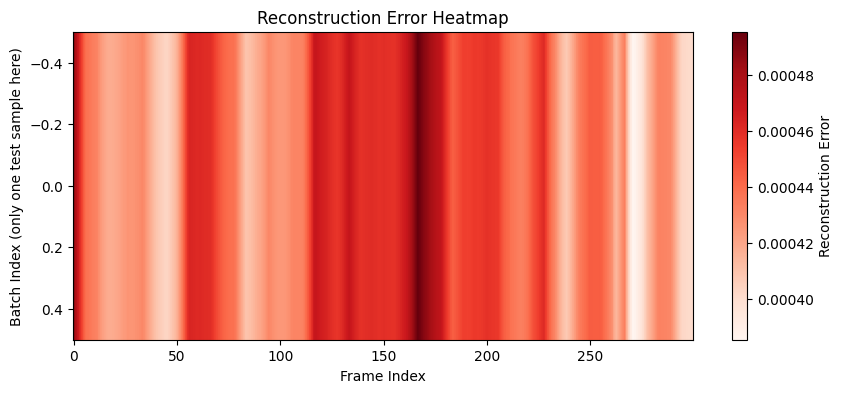

In [6]:
import matplotlib.pyplot as plt
import numpy as np

# Calculate per-frame reconstruction errors
with torch.no_grad():
    reconstruction = autoencoder(test_data)
    errors = torch.mean((test_data - reconstruction) ** 2, dim=2).cpu().numpy()  # Shape: (1, seq_length)

# Plot the heatmap
plt.figure(figsize=(10, 4))
plt.imshow(errors, aspect='auto', cmap='Reds')
plt.colorbar(label="Reconstruction Error")
plt.xlabel("Frame Index")
plt.ylabel("Batch Index (only one test sample here)")
plt.title("Reconstruction Error Heatmap")
plt.show()


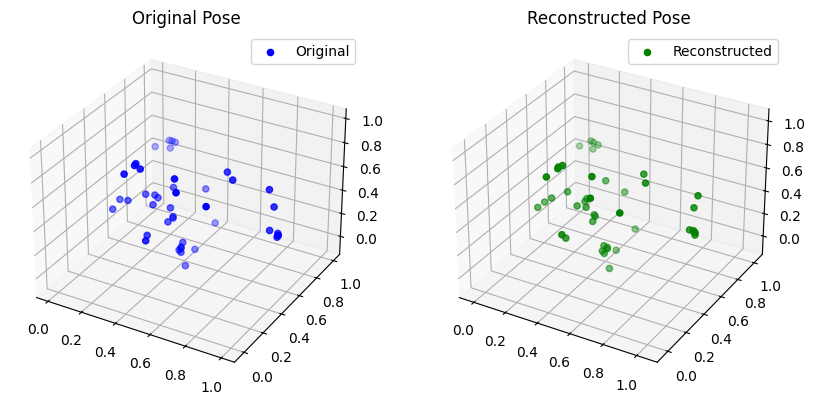

In [7]:
# Choose a specific frame index
frame_idx = 50  # For example, the 50th frame
original_frame = test_data[0, frame_idx].cpu().numpy().reshape(-1, 3)
reconstructed_frame = reconstruction[0, frame_idx].cpu().numpy().reshape(-1, 3)

# Plot original vs reconstructed pose
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(121, projection='3d')
ax.scatter(original_frame[:, 0], original_frame[:, 1], original_frame[:, 2], c='blue', label='Original')
ax.set_title('Original Pose')
ax.legend()

ax2 = fig.add_subplot(122, projection='3d')
ax2.scatter(reconstructed_frame[:, 0], reconstructed_frame[:, 1], reconstructed_frame[:, 2], c='green', label='Reconstructed')
ax2.set_title('Reconstructed Pose')
ax2.legend()

plt.show()


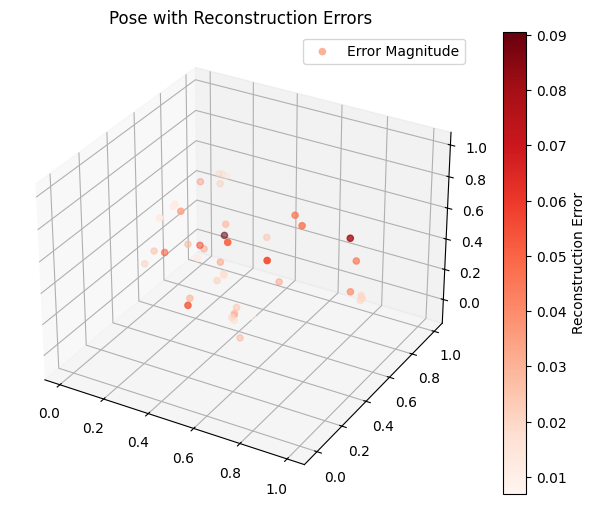

In [8]:
# Calculate per-landmark errors for a specific frame
frame_errors = np.linalg.norm(original_frame - reconstructed_frame, axis=1)

# Plot pose with errors
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
sc = ax.scatter(original_frame[:, 0], original_frame[:, 1], original_frame[:, 2],
                c=frame_errors, cmap='Reds', label='Error Magnitude')
ax.set_title('Pose with Reconstruction Errors')
plt.colorbar(sc, label="Reconstruction Error")
ax.legend()
plt.show()


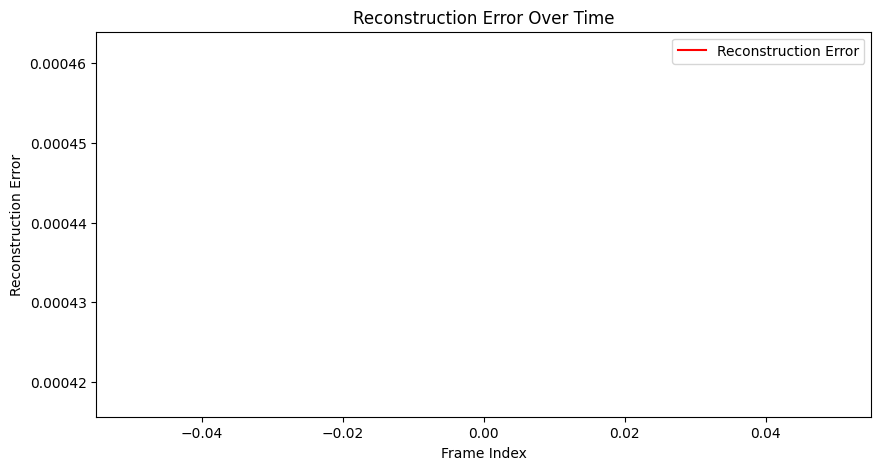

In [9]:
# Calculate reconstruction errors per frame
temporal_errors = np.mean(errors, axis=1)  # Average over landmarks

# Plot temporal errors
plt.figure(figsize=(10, 5))
plt.plot(temporal_errors, label='Reconstruction Error', color='red')
plt.xlabel('Frame Index')
plt.ylabel('Reconstruction Error')
plt.title('Reconstruction Error Over Time')
plt.legend()
plt.show()


[0]


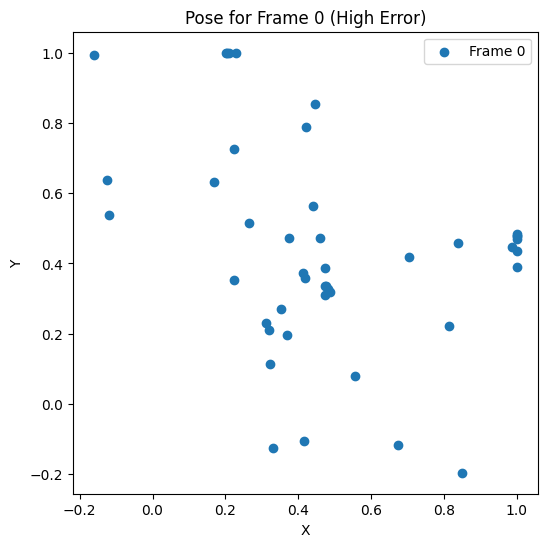

In [10]:
# Identify frames with high errors
temporal_errors
top_error_indices = np.argsort(-temporal_errors)[:5] 
print(top_error_indices)# Top 5 frames with highest errors

# Visualize these frames
for frame_idx in top_error_indices:
    frame = test_data[0, frame_idx].cpu().numpy().reshape(-1, 3)
    plt.figure(figsize=(6, 6))
    plt.scatter(frame[:, 0], frame[:, 1], label=f'Frame {frame_idx}')
    plt.title(f"Pose for Frame {frame_idx} (High Error)")
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.legend()
    plt.show()


In [11]:
BODY_CONNECTIONS = [
    (0, 1), (1, 2), (2, 3), (3, 7), (0, 4), (4, 5), (5, 6), (6, 8),
    (9, 10), (11, 12), (11, 13), (13, 15), (12, 14), (14, 16),
    (11, 23), (12, 24), (23, 24), (23, 25), (25, 27), (24, 26), (26, 28),
    (27, 29), (29, 31), (28, 30), (30, 32)
]

BODY_PART_NAMES = [
    "Nose", "Left Eye Inner", "Left Eye", "Left Eye Outer", "Right Eye Inner", "Right Eye", "Right Eye Outer", "Left Ear", "Right Ear",
    "Mouth Left", "Mouth Right", "Left Shoulder", "Right Shoulder", "Left Elbow", "Right Elbow", "Left Wrist", "Right Wrist",
    "Left Pinky", "Right Pinky", "Left Index", "Right Index", "Left Thumb", "Right Thumb",
    "Left Hip", "Right Hip", "Left Knee", "Right Knee", "Left Ankle", "Right Ankle",
    "Left Heel", "Right Heel", "Left Foot Index", "Right Foot Index"
]

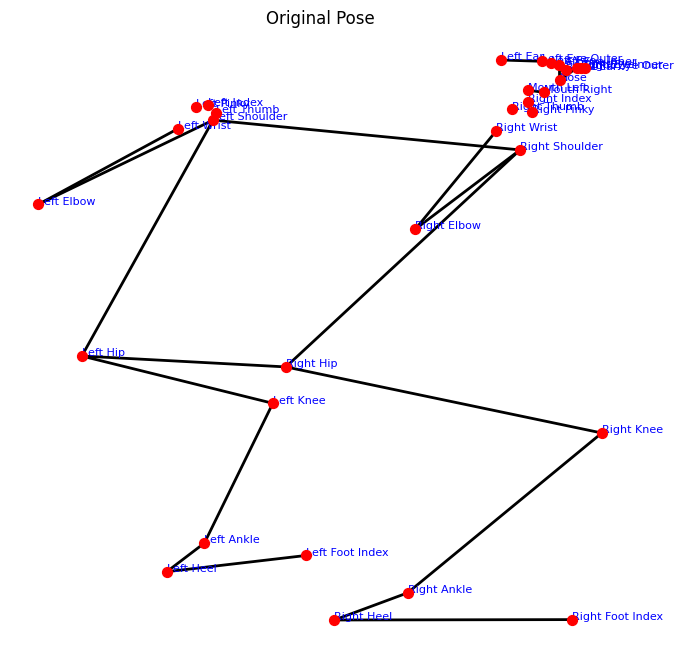

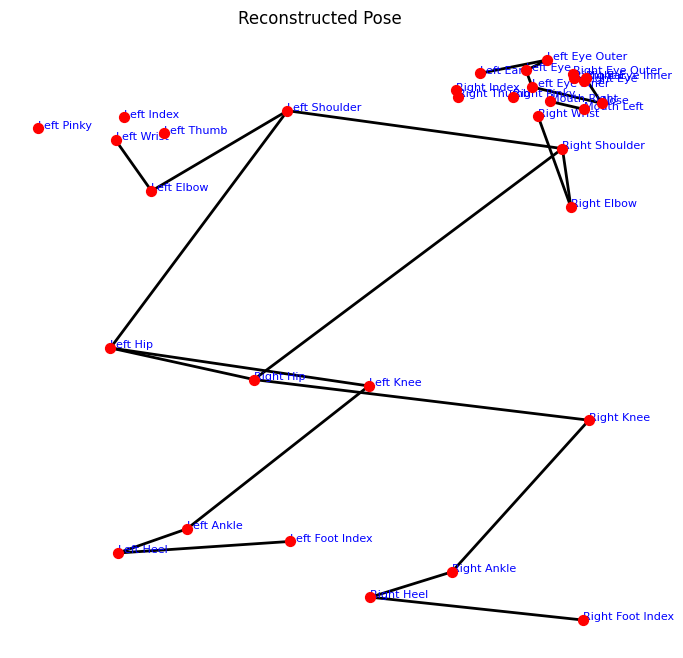

In [12]:
# Parse the 132-dimensional data into 33 landmarks with 4 dimensions (x, y, z, visibility)
def parse_landmarks(frame):
    return frame.reshape(33, 4)  # Reshape to 33 landmarks with 4 dimensions

# Function to plot a pose with labels
def plot_pose_with_labels(landmarks, title):
    plt.figure(figsize=(8, 8))
    for connection in BODY_CONNECTIONS:
        start, end = connection
        plt.plot(
            [landmarks[start, 0], landmarks[end, 0]],
            [landmarks[start, 1], landmarks[end, 1]],
            color='black', linewidth=2
        )
    plt.scatter(landmarks[:, 0], landmarks[:, 1], color='red', s=50, zorder=5)
    for idx, (x, y) in enumerate(landmarks[:, :2]):
        plt.text(x, y, BODY_PART_NAMES[idx], fontsize=8, color="blue")
    plt.title(title)
    plt.axis("off")
    plt.gca().invert_yaxis()  # Invert Y-axis for a better view (Mediapipe style)
    plt.show()

# Example: Visualize original and reconstructed poses for a specific frame
frame_idx = 50  # Example frame index
original_frame = parse_landmarks(test_data[0, frame_idx].cpu().numpy())[:, :2]  # X, Y coordinates
reconstructed_frame = parse_landmarks(reconstruction[0, frame_idx].cpu().numpy())[:, :2]

plot_pose_with_labels(original_frame, "Original Pose")
plot_pose_with_labels(reconstructed_frame, "Reconstructed Pose")


In [13]:
# Calculate per-landmark errors for a specific frame
errors_per_landmark = np.linalg.norm(
    parse_landmarks(test_data[0, frame_idx].cpu().numpy())[:, :3] -  # Ignore visibility
    parse_landmarks(reconstruction[0, frame_idx].cpu().numpy())[:, :3],
    axis=1
)

# Define a threshold for acceptable error
landmark_threshold = 0.03  # Adjust based on your data range
out_of_threshold_indices = np.where(errors_per_landmark > landmark_threshold)[0]

# Print problematic landmarks with their names and error values
print("Problematic Landmarks:")
for idx in out_of_threshold_indices:
    print(f"{BODY_PART_NAMES[idx]} (Landmark {idx}): Error = {errors_per_landmark[idx]:.4f}")


Problematic Landmarks:
Nose (Landmark 0): Error = 0.0303
Mouth Left (Landmark 9): Error = 0.0306
Left Shoulder (Landmark 11): Error = 0.0369
Left Elbow (Landmark 13): Error = 0.0365
Right Elbow (Landmark 14): Error = 0.0543
Right Wrist (Landmark 16): Error = 0.0311
Left Pinky (Landmark 17): Error = 0.0301
Left Knee (Landmark 25): Error = 0.0428
Right Knee (Landmark 26): Error = 0.0319
Right Ankle (Landmark 28): Error = 0.0441
Right Heel (Landmark 30): Error = 0.0417
Left Foot Index (Landmark 31): Error = 0.0322
Right Foot Index (Landmark 32): Error = 0.0302


In [14]:
# Calculate total errors for the test exercise
total_original_error = np.sum(np.linalg.norm(test_data.cpu().numpy() - 0, axis=2))  # Baseline (zero reference)
total_reconstruction_error = np.sum(np.linalg.norm(test_data.cpu().numpy() - reconstruction.cpu().numpy(), axis=2))

# Compute percentage accuracy
accuracy = 100 * (1 - (total_reconstruction_error / total_original_error))
print(f"Exercise Accuracy: {accuracy:.2f}%")


Exercise Accuracy: 96.26%


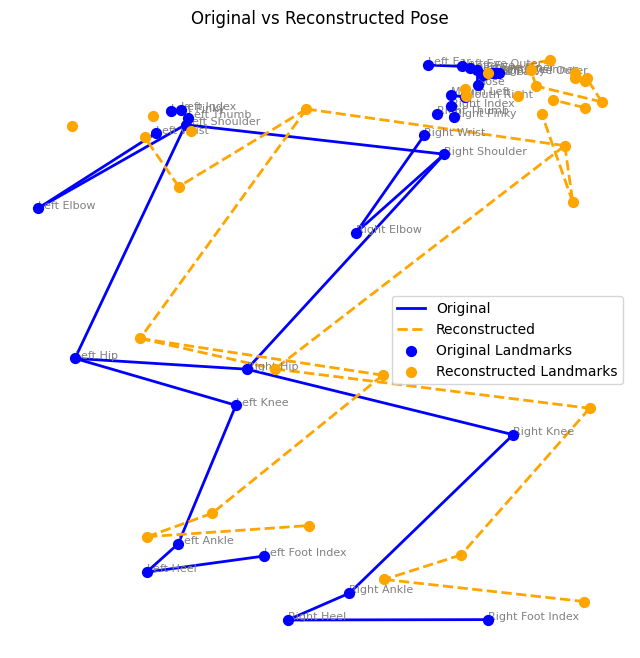

In [15]:
# Function to plot both original and reconstructed poses on the same plot
def plot_original_and_reconstructed(original, reconstructed, title):
    plt.figure(figsize=(8, 8))
    # Plot connections for the original pose
    for connection in BODY_CONNECTIONS:
        start, end = connection
        plt.plot(
            [original[start, 0], original[end, 0]],
            [original[start, 1], original[end, 1]],
            color='blue', linewidth=2, label="Original" if connection == BODY_CONNECTIONS[0] else ""
        )
    # Plot connections for the reconstructed pose
    for connection in BODY_CONNECTIONS:
        start, end = connection
        plt.plot(
            [reconstructed[start, 0], reconstructed[end, 0]],
            [reconstructed[start, 1], reconstructed[end, 1]],
            color='orange', linewidth=2, linestyle='--', label="Reconstructed" if connection == BODY_CONNECTIONS[0] else ""
        )
    # Scatter plot for landmarks
    plt.scatter(original[:, 0], original[:, 1], color='blue', label="Original Landmarks", s=50, zorder=5)
    plt.scatter(reconstructed[:, 0], reconstructed[:, 1], color='orange', label="Reconstructed Landmarks", s=50, zorder=5)
    
    # Add landmark names for clarity
    for idx, (x, y) in enumerate(original[:, :2]):
        plt.text(x, y, BODY_PART_NAMES[idx], fontsize=8, color="gray")

    plt.title(title)
    plt.axis("off")
    plt.gca().invert_yaxis()  # Invert Y-axis for a better view (Mediapipe style)
    plt.legend()
    plt.show()

# Example: Visualize the combined plot for a specific frame
plot_original_and_reconstructed(original_frame, reconstructed_frame, "Original vs Reconstructed Pose")


In [16]:
import matplotlib.pyplot as plt
import numpy as np
import os

# Ensure output directory exists
output_dir = "output_gif"
os.makedirs(output_dir, exist_ok=True)

# Function to plot both original and reconstructed poses for a specific frame
def plot_frame(frame_idx, original, reconstructed):
    plt.figure(figsize=(8, 8))
    for connection in BODY_CONNECTIONS:
        start, end = connection
        # Original pose connections
        plt.plot(
            [original[start, 0], original[end, 0]],
            [original[start, 1], original[end, 1]],
            color='blue', linewidth=2, label="Original" if connection == BODY_CONNECTIONS[0] else ""
        )
        # Reconstructed pose connections
        plt.plot(
            [reconstructed[start, 0], reconstructed[end, 0]],
            [reconstructed[start, 1], reconstructed[end, 1]],
            color='orange', linewidth=2, linestyle='--', label="Reconstructed" if connection == BODY_CONNECTIONS[0] else ""
        )
    plt.scatter(original[:, 0], original[:, 1], color='blue', s=50, zorder=5, label="Original Landmarks")
    plt.scatter(reconstructed[:, 0], reconstructed[:, 1], color='orange', s=50, zorder=5, label="Reconstructed Landmarks")
    plt.title(f"Frame {frame_idx + 1}")
    plt.axis("off")
    plt.gca().invert_yaxis()
    if frame_idx == 0:  # Add legend only for the first frame
        plt.legend()
    plt.savefig(f"{output_dir}/frame_{frame_idx:03d}.png")
    plt.close()

# Create frames for all 300 frames
for frame_idx in range(300):
    original_frame = parse_landmarks(test_data[0, frame_idx].cpu().numpy())[:, :2]
    reconstructed_frame = parse_landmarks(reconstruction[0, frame_idx].cpu().numpy())[:, :2]
    plot_frame(frame_idx, original_frame, reconstructed_frame)

# Create a GIF from the frames



In [17]:
import imageio

frames = []
for frame_idx in range(300):
    frame_path = f"{output_dir}/frame_{frame_idx:03d}.png"
    frames.append(imageio.imread(frame_path))

gif_path = "original_vs_reconstructed_fine_tuned.gif"
imageio.mimsave(gif_path, frames, fps=30)  # Adjust FPS as needed

print(f"GIF saved to {gif_path}")

C:\Users\barrt\AppData\Local\Temp\ipykernel_5564\2057395976.py:6: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  frames.append(imageio.imread(frame_path))


GIF saved to original_vs_reconstructed_fine_tuned.gif


In [18]:
# Evaluate reconstruction errors for the entire test dataset
test_reconstruction_errors = []
test_labels = []  # Store labels to identify potential issues

with torch.no_grad():
    for batch in test_loader:
        X_batch, y_batch = batch
        X_batch = X_batch.to(device, non_blocking=True)  # Move input to the same device as the model
        reconstruction = autoencoder(X_batch)
        errors = torch.mean((X_batch - reconstruction) ** 2, dim=(1, 2))  # Compute MSE per sample
        test_reconstruction_errors.extend(errors.cpu().numpy())  # Collect errors
        test_labels.extend(y_batch.cpu().numpy())  # Collect corresponding labels

# Use the same threshold from training
wrong_exercises = [(idx, error, label) for idx, (error, label) in enumerate(zip(test_reconstruction_errors, test_labels)) if error > threshold]

# Prepare results for visualization or summary

results = pd.DataFrame(wrong_exercises, columns=["Index", "Reconstruction Error", "Label"])
results = results.sort_values(by="Reconstruction Error", ascending=False)



In [19]:
results

,Index,Reconstruction Error,Label
2,7,0.002139,4
11,36,0.000592,2
14,43,0.000522,1
10,32,0.000511,0
13,42,0.000493,1
1,4,0.000449,0
0,1,0.000440,2
3,10,0.000434,0
8,29,0.000429,0
4,15,0.000426,0


In [20]:
import numpy as np

# Parse the input and reconstructed data (for a single frame)
def calculate_landmark_errors(input_frame, reconstructed_frame):
    input_landmarks = input_frame.reshape(33, 4)  # 33 landmarks x (x, y, z, visibility)
    reconstructed_landmarks = reconstructed_frame.reshape(33, 4)
    
    # Calculate Euclidean distance for each landmark (ignoring visibility for error calculation)
    errors = np.linalg.norm(input_landmarks[:, :3] - reconstructed_landmarks[:, :3], axis=1)
    return errors


In [21]:
# Example: Evaluate errors for a single frame
errors = calculate_landmark_errors(test_data[0], reconstructed_frame)

# Define a threshold for misalignment
threshold = 0.02  # Adjust based on your data

# Identify misaligned landmarks
misaligned_landmarks = np.where(errors > threshold)[0]
print("Misaligned Landmarks:", misaligned_landmarks)


RuntimeError: shape '[33, 4]' is invalid for input of size 39600

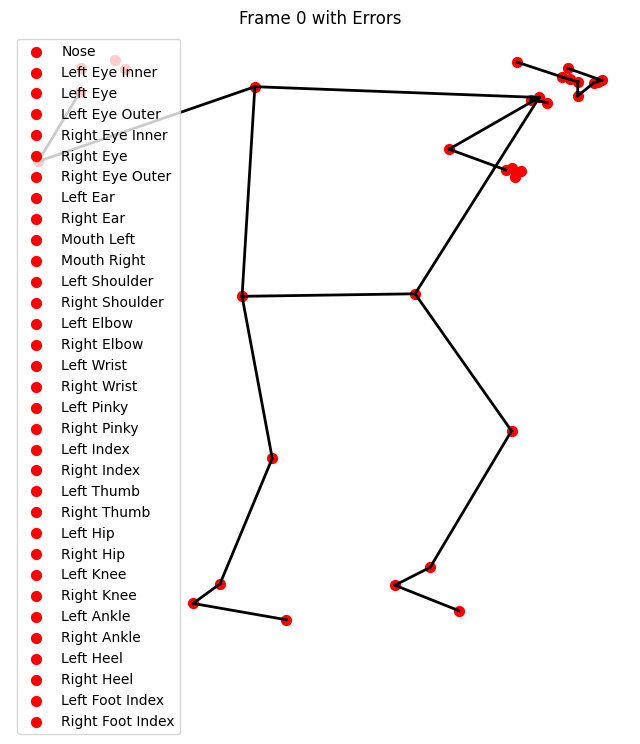

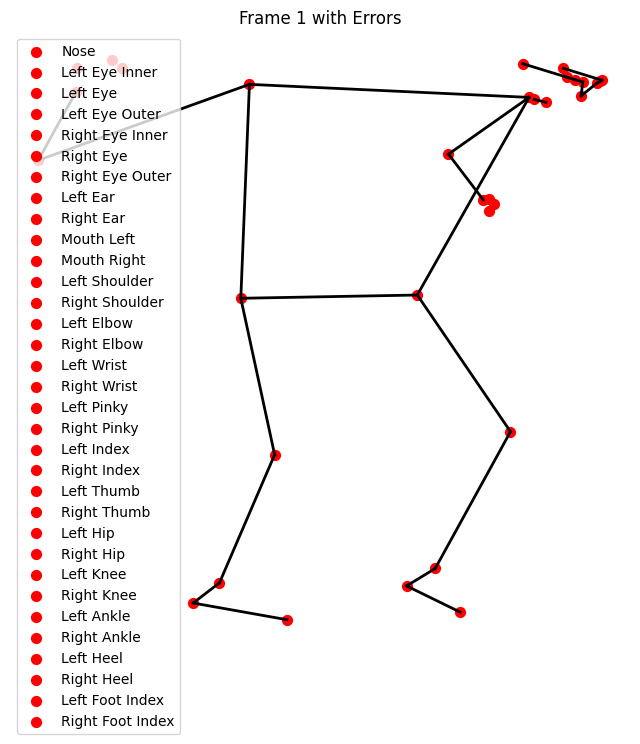

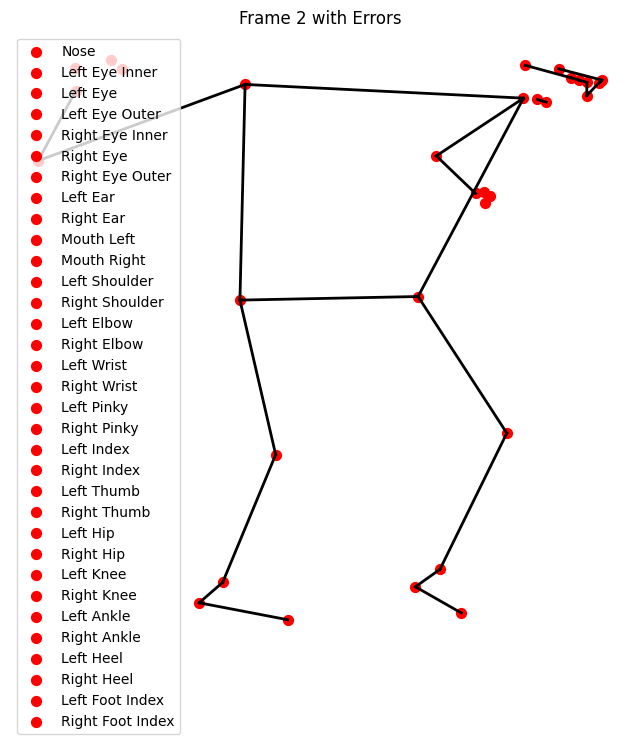

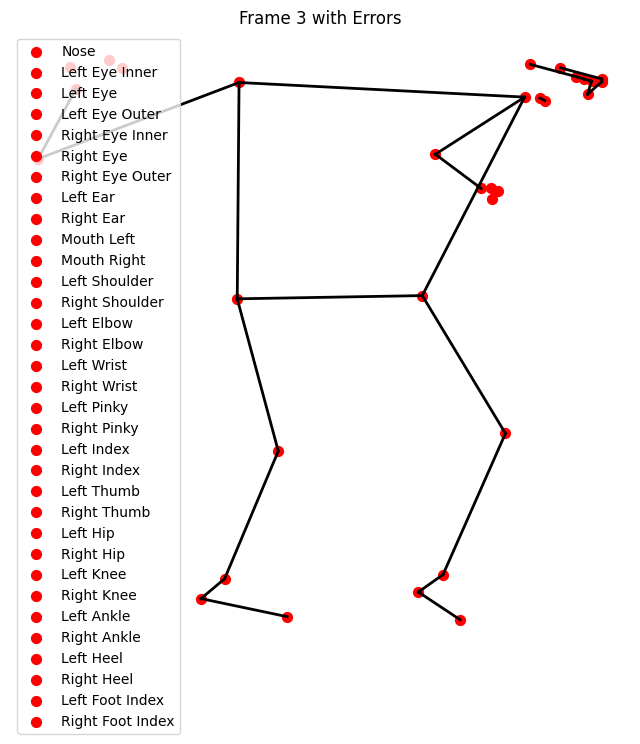

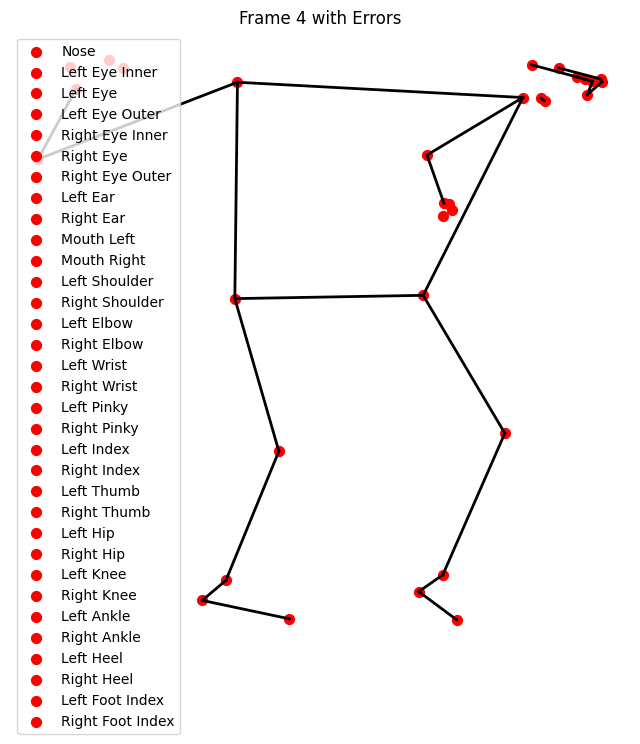

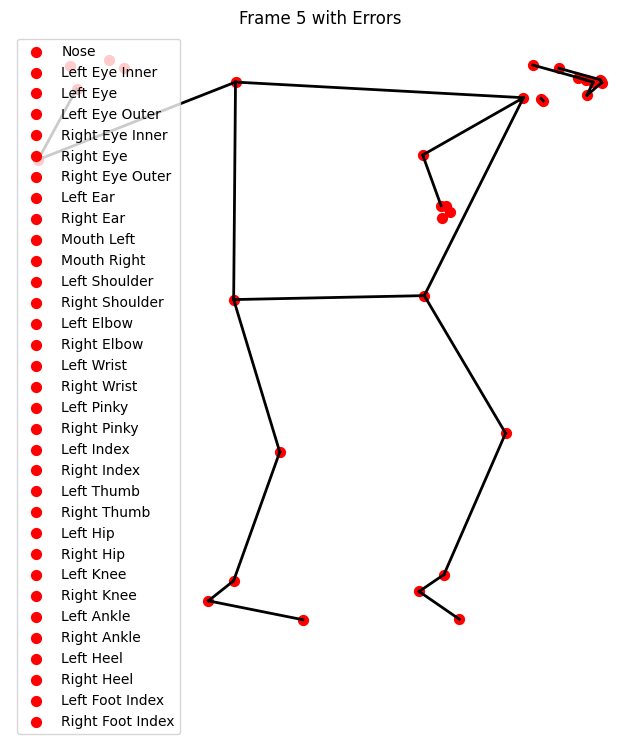

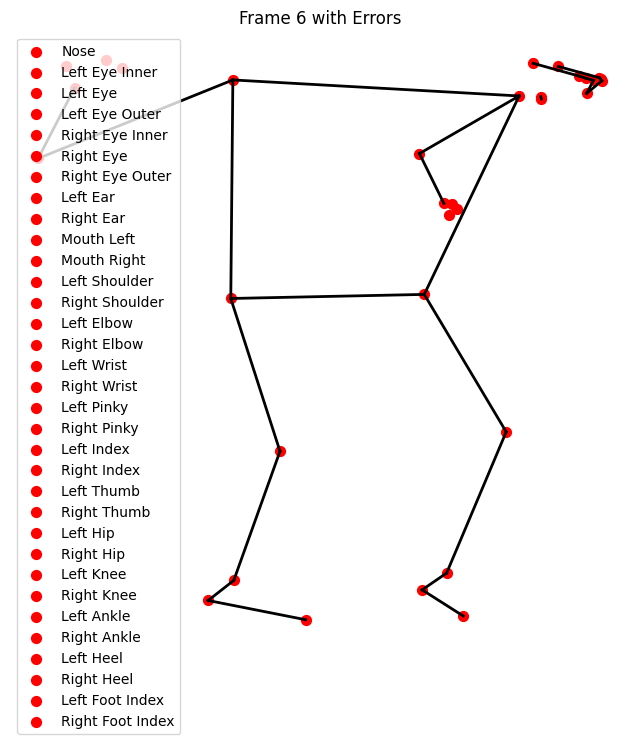

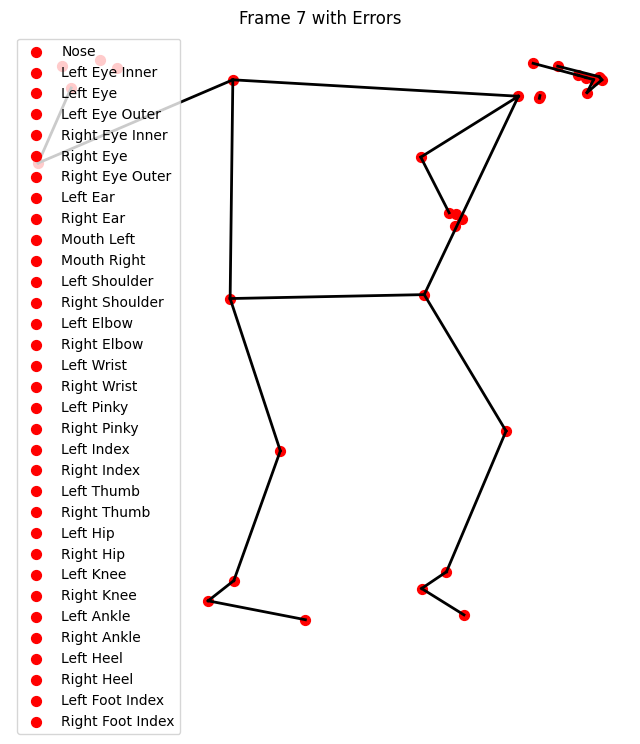

KeyboardInterrupt: 

In [22]:
import torch
import numpy as np
import matplotlib.pyplot as plt

# Mediapipe-style body part names
BODY_PART_NAMES = [
    "Nose", "Left Eye Inner", "Left Eye", "Left Eye Outer", "Right Eye Inner", "Right Eye", "Right Eye Outer",
    "Left Ear", "Right Ear", "Mouth Left", "Mouth Right", "Left Shoulder", "Right Shoulder",
    "Left Elbow", "Right Elbow", "Left Wrist", "Right Wrist", "Left Pinky", "Right Pinky",
    "Left Index", "Right Index", "Left Thumb", "Right Thumb", "Left Hip", "Right Hip",
    "Left Knee", "Right Knee", "Left Ankle", "Right Ankle", "Left Heel", "Right Heel",
    "Left Foot Index", "Right Foot Index"
]

# Mediapipe-style landmark connections
BODY_CONNECTIONS = [
    (0, 1), (1, 2), (2, 3), (3, 7), (0, 4), (4, 5), (5, 6), (6, 8),
    (9, 10), (11, 12), (11, 13), (13, 15), (12, 14), (14, 16),
    (11, 23), (12, 24), (23, 24), (23, 25), (25, 27), (24, 26), (26, 28),
    (27, 29), (29, 31), (28, 30), (30, 32)
]

# Parse landmarks from a frame
def parse_landmarks(frame):
    return frame.reshape(33, 4)  # 33 landmarks x (x, y, z, visibility)

# Function to calculate per-landmark errors
def calculate_landmark_errors(input_frame, reconstructed_frame):
    input_landmarks = parse_landmarks(input_frame)[:, :3]  # Ignore visibility for error calculation
    reconstructed_landmarks = parse_landmarks(reconstructed_frame)[:, :3]
    errors = np.linalg.norm(input_landmarks - reconstructed_landmarks, axis=1)  # Euclidean distance
    return errors

# Function to identify problematic landmarks
def identify_problematic_landmarks(errors, threshold=0.02):
    return [idx for idx, error in enumerate(errors) if error > threshold]

# Visualize problematic landmarks
def visualize_pose_with_errors(landmarks, errors, threshold, title):
    plt.figure(figsize=(8, 8))
    landmarks = landmarks[:, :2]  # Use only x, y for plotting
    for connection in BODY_CONNECTIONS:
        start, end = connection
        plt.plot(
            [landmarks[start, 0], landmarks[end, 0]],
            [landmarks[start, 1], landmarks[end, 1]],
            color='black', linewidth=2
        )
    for idx, (x, y) in enumerate(landmarks):
        color = 'red' if errors[idx] > threshold else 'blue'
        plt.scatter(x, y, color=color, s=50, label=BODY_PART_NAMES[idx] if errors[idx] > threshold else "")
    plt.title(title)
    plt.axis("off")
    plt.gca().invert_yaxis()
    plt.legend()
    plt.show()

# Evaluation on the entire test set
problematic_landmarks_results = []  # To store results for each frame

autoencoder.eval()
with torch.no_grad():
    for frame_idx in range(X_test.shape[1]):  # Loop over frames
        input_frame = X_test[0, frame_idx]  # Example: First test sample
        reconstructed_frame = reconstruction[0, frame_idx].cpu().numpy()

        # Calculate errors and identify problematic landmarks
        errors = calculate_landmark_errors(input_frame, reconstructed_frame)
        problematic_landmarks = identify_problematic_landmarks(errors)

        # Save results
        problematic_landmarks_results.append({
            "Frame": frame_idx,
            "Errors": errors,
            "Problematic Landmarks": [BODY_PART_NAMES[idx] for idx in problematic_landmarks]
        })

        # Visualize the frame with problematic landmarks
        visualize_pose_with_errors(
            parse_landmarks(input_frame),
            errors,
            threshold=0.02,
            title=f"Frame {frame_idx} with Errors"
        )


In [78]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import imageio
import os

# Mediapipe-style body part names
BODY_PART_NAMES = [
    "Nose", "Left Eye Inner", "Left Eye", "Left Eye Outer", "Right Eye Inner", "Right Eye", "Right Eye Outer",
    "Left Ear", "Right Ear", "Mouth Left", "Mouth Right", "Left Shoulder", "Right Shoulder",
    "Left Elbow", "Right Elbow", "Left Wrist", "Right Wrist", "Left Pinky", "Right Pinky",
    "Left Index", "Right Index", "Left Thumb", "Right Thumb", "Left Hip", "Right Hip",
    "Left Knee", "Right Knee", "Left Ankle", "Right Ankle", "Left Heel", "Right Heel",
    "Left Foot Index", "Right Foot Index"
]

# Mediapipe-style landmark connections
BODY_CONNECTIONS = [
    (0, 1), (1, 2), (2, 3), (3, 7), (0, 4), (4, 5), (5, 6), (6, 8),
    (9, 10), (11, 12), (11, 13), (13, 15), (12, 14), (14, 16),
    (11, 23), (12, 24), (23, 24), (23, 25), (25, 27), (24, 26), (26, 28),
    (27, 29), (29, 31), (28, 30), (30, 32)
]

# Parse landmarks from a frame
def parse_landmarks(frame):
    return frame.reshape(33, 4)  # 33 landmarks x (x, y, z, visibility)

# Function to calculate per-landmark errors
def calculate_landmark_errors(input_frame, reconstructed_frame):
    input_landmarks = parse_landmarks(input_frame)[:, :3]  # Ignore visibility for error calculation
    reconstructed_landmarks = parse_landmarks(reconstructed_frame)[:, :3]
    errors = np.linalg.norm(input_landmarks - reconstructed_landmarks, axis=1)  # Euclidean distance
    return errors

# Function to identify problematic landmarks
def identify_problematic_landmarks(errors, threshold):
    return [idx for idx, error in enumerate(errors) if error > threshold]

# Visualize problematic landmarks
def visualize_pose_with_errors(landmarks, errors, threshold, title, frame_path):
    plt.figure(figsize=(8, 8))
    landmarks = landmarks[:, :2]  # Use only x, y for plotting
    for connection in BODY_CONNECTIONS:
        start, end = connection
        plt.plot(
            [landmarks[start, 0], landmarks[end, 0]],
            [landmarks[start, 1], landmarks[end, 1]],
            color='black', linewidth=2
        )
    for idx, (x, y) in enumerate(landmarks):
        color = 'red' if errors[idx] > threshold*40 else 'blue'
        plt.scatter(x, y, color=color, s=50, label=BODY_PART_NAMES[idx] if errors[idx] > threshold else "")
    plt.title(title)
    plt.axis("off")
    plt.gca().invert_yaxis()
    if idx == 0:  # Add legend only for the first frame
        plt.legend()
    plt.savefig(frame_path)
    plt.close()

# Compute train reconstruction errors
train_reconstruction_errors = []
autoencoder.eval()
with torch.no_grad():
    for batch in train_loader:
        X_batch, _ = batch
        X_batch = X_batch.to(device)
        reconstruction = autoencoder(X_batch)
        errors = torch.mean((X_batch - reconstruction) ** 2, dim=(1, 2))
        train_reconstruction_errors.extend(errors.cpu().numpy())

# Automatically set threshold
threshold = np.percentile(train_reconstruction_errors, 95)
print(f"Automatically Set Threshold: {threshold:.4f}")

# Create directory for saving frames
os.makedirs("frames", exist_ok=True)
output_frames = []

# Evaluate the test dataset and create frames for the GIF
with torch.no_grad():
    for frame_idx in range(X_test.shape[1]):  # Loop over all frames
        input_frame = X_test[0, frame_idx]  # First test sample
        reconstructed_frame = reconstruction[0, frame_idx].cpu().numpy()
        errors = calculate_landmark_errors(input_frame, reconstructed_frame)
        problematic_landmarks = identify_problematic_landmarks(errors, threshold)
        frame_path = f"frames/frame_{frame_idx:03d}.png"
        visualize_pose_with_errors(
            parse_landmarks(input_frame),
            errors,
            threshold,
            title=f"Frame {frame_idx + 1} with Errors",
            frame_path=frame_path
        )
        output_frames.append(frame_path)

# Create GIF
gif_path = "exercise_errors.gif"
frames = [imageio.imread(frame) for frame in output_frames]
imageio.mimsave(gif_path, frames, fps=30)  # Adjust FPS as needed
print(f"GIF saved to {gif_path}")


Automatically Set Threshold: 0.0011


C:\Users\barrt\AppData\Local\Temp\ipykernel_26996\1051509903.py:100: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  frames = [imageio.imread(frame) for frame in output_frames]


GIF saved to exercise_errors.gif


In [98]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Automatically set threshold per landmark based on training reconstruction errors
train_landmark_errors = []

# Step 1: Collect landmark reconstruction errors during training
autoencoder.eval()
with torch.no_grad():
    for batch in train_loader:
        X_batch, _ = batch
        X_batch = X_batch.to(device)
        reconstruction = autoencoder(X_batch)
        batch_errors = torch.norm(
            (X_batch - reconstruction).reshape(-1, 33, 4)[:, :, :3], dim=2
        ).cpu().numpy()  # Shape: (batch_size, 33 landmarks)
        train_landmark_errors.extend(batch_errors)

# Convert to NumPy array for threshold calculation
train_landmark_errors = np.array(train_landmark_errors)  # Shape: (num_samples, 33 landmarks)

# Step 2: Set threshold for each landmark
landmark_thresholds = np.percentile(train_landmark_errors, 1, axis=0)  # 95th percentile per landmark

# Step 3: Evaluate problematic landmarks every 60th frame
problematic_landmarks_summary = []

with torch.no_grad():
    for frame_idx in range(0, X_test.shape[1], 60):  # Every 60th frame
        input_frame = X_test[0, frame_idx]  # First test sample
        reconstructed_frame = reconstruction[0, frame_idx].cpu().numpy()

        # Calculate per-landmark errors
        input_landmarks = parse_landmarks(input_frame)[:, :3]
        reconstructed_landmarks = parse_landmarks(reconstructed_frame)[:, :3]
        errors = np.linalg.norm(input_landmarks - reconstructed_landmarks, axis=1)

        # Identify problematic landmarks
        for idx, error in enumerate(errors):
            if error > landmark_thresholds[idx]:  # Compare error to its specific threshold
                problematic_landmarks_summary.append({
                    "Frame": frame_idx,
                    "Landmark": BODY_PART_NAMES[idx],
                    "Error": error,
                    "Threshold": landmark_thresholds[idx]
                })

# Step 4: Create a DataFrame for readability
landmark_errors_df = pd.DataFrame(problematic_landmarks_summary)

In [99]:
landmark_errors_df

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32]

In [100]:
with torch.no_grad():
    sample = torch.tensor(X_test[0], dtype=torch.float32).unsqueeze(0).to(device)
    reconstructed = autoencoder(sample)
    print("Input Sample:", sample[0, 0, :10])  # Print first 10 features
    print("Reconstructed Sample:", reconstructed[0, 0, :10].cpu())  # Print first 10 features


Input Sample: tensor([ 0.5311,  0.4288, -0.1818,  0.9956,  0.5363,  0.4102, -0.1717,  0.9840,
         0.5376,  0.4081], device='cuda:0')
Reconstructed Sample: tensor([ 0.5290,  0.4174, -0.1992,  1.0092,  0.5398,  0.4010, -0.1814,  0.9947,
         0.5426,  0.3934])


In [102]:
relative_error = torch.abs(sample - reconstructed) / (torch.abs(sample) + 1e-7)
relative_error

tensor([[[4.0575e-03, 2.6625e-02, 9.5615e-02,  ..., 5.9424e-03,
          1.2507e+00, 2.1464e-01],
         [9.5804e-03, 1.5717e-02, 2.5555e-01,  ..., 8.0114e-03,
          2.4475e+00, 2.0991e-01],
         [6.0862e-03, 5.7813e-03, 2.0941e-01,  ..., 1.7876e-02,
          3.1421e+00, 2.3496e-01],
         ...,
         [5.5255e-03, 4.4042e-02, 4.9771e-03,  ..., 3.2550e-02,
          9.8694e-02, 1.1426e-01],
         [4.3115e-03, 4.9304e-02, 1.7878e-02,  ..., 3.2408e-02,
          9.3524e-02, 1.0747e-01],
         [1.9295e-03, 5.6709e-02, 3.6458e-02,  ..., 3.0819e-02,
          6.4680e-02, 9.2166e-02]]], device='cuda:0')

In [108]:
# Select the first sample and focus on a specific frame (e.g., frame_idx = 0)
frame_idx = 0  # Example frame index
relative_error_frame = relative_error[0, frame_idx].view(33, 4)  # Reshape to (33 landmarks x 4 dimensions)

# Calculate mean relative error per landmark (reduce dimensions: x, y, z)
relative_error_mean = relative_error_frame[:, :3].mean(dim=1)  # Mean error for x, y, z per landmark

# Identify landmarks with relative error exceeding the threshold
relative_threshold = 0.05  # 5%
problematic_indices = (relative_error_mean > relative_threshold).nonzero(as_tuple=True)[0]

# Print problematic landmarks
print("Problematic Landmarks:")
for idx in problematic_indices:
    print(f"Landmark {BODY_PART_NAMES[idx]}: Relative Error = {relative_error_mean[idx].item():.4f}")


Problematic Landmarks:
Landmark Left Shoulder: Relative Error = 0.1607
Landmark Right Shoulder: Relative Error = 0.0506
Landmark Left Hip: Relative Error = 0.1006
Landmark Right Hip: Relative Error = 0.1044
Landmark Left Knee: Relative Error = 0.1468
Landmark Right Knee: Relative Error = 0.1255
Landmark Right Ankle: Relative Error = 0.0709
Landmark Left Heel: Relative Error = 0.0643
Landmark Left Foot Index: Relative Error = 0.0906
Landmark Right Foot Index: Relative Error = 0.4362


In [32]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Automatically set relative error threshold per landmark based on training reconstruction errors
train_landmark_relative_errors = []

# Step 1: Collect relative errors during training
autoencoder.eval()
with torch.no_grad():
    for batch in train_loader:
        X_batch, _ = batch
        X_batch = X_batch.to(device)
        reconstruction = autoencoder(X_batch)
        # Calculate relative errors
        batch_relative_errors = torch.abs(X_batch - reconstruction) / (torch.abs(X_batch) + 1e-7)
        batch_relative_errors = batch_relative_errors.view(-1, 33, 4)[:, :, :3].mean(dim=2)  # Reduce to mean for x, y, z
        train_landmark_relative_errors.extend(batch_relative_errors.cpu().numpy())

# Convert to NumPy array for threshold calculation
train_landmark_relative_errors = np.array(train_landmark_relative_errors)  # Shape: (num_samples, 33 landmarks)

# Step 2: Set threshold for each landmark
landmark_thresholds = np.percentile(train_landmark_relative_errors, 80, axis=0)  # 95th percentile per landmark

# Step 3: Evaluate problematic landmarks every 60th frame
problematic_landmarks_summary = []

with torch.no_grad():
    for frame_idx in range(0, X_test.shape[1], 60):  # Every 60th frame
        input_frame = torch.tensor(X_test[30, frame_idx], dtype=torch.float32).unsqueeze(0).unsqueeze(1).to(device)
        # Reshape input_frame to (batch_size=1, sequence_length=1, input_dim=132)

        reconstructed_frame = autoencoder(input_frame)

        # Calculate relative errors
        relative_errors = torch.abs(input_frame - reconstructed_frame) / (torch.abs(input_frame) + 1e-7)
        relative_errors = relative_errors.view(33, 4)[:, :3].mean(dim=1)  # Reduce to mean for x, y, z

        # Identify problematic landmarks
        for idx, relative_error in enumerate(relative_errors):
            if relative_error.item() > landmark_thresholds[idx]:  # Compare relative error to its threshold
                problematic_landmarks_summary.append({
                    "Frame": frame_idx,
                    "Landmark": BODY_PART_NAMES[idx],
                    "Relative Error": relative_error.item(),
                    "Threshold": landmark_thresholds[idx]
                })


# Step 4: Create a DataFrame for readability
landmark_errors_df = pd.DataFrame(problematic_landmarks_summary)
landmark_errors_df


,Frame,Landmark,Relative Error,Threshold
0,0,Right Eye Inner,0.064739,0.042786
1,0,Right Ear,0.063113,0.062360
2,0,Left Shoulder,1.891420,0.053048
3,0,Left Elbow,0.218413,0.051776
4,0,Right Elbow,0.087714,0.071678
5,0,Left Wrist,0.033939,0.033536
6,0,Left Pinky,0.048019,0.044069
7,0,Right Knee,0.492281,0.101747
8,60,Left Eye Outer,0.054627,0.041417
9,60,Right Eye Inner,0.059602,0.042786


In [33]:
# Define relevant landmarks for each exercise
exercise_landmarks = {
    "push-up": ["Left Shoulder", "Right Shoulder", "Left Elbow", "Right Elbow", "Left Wrist", "Right Wrist"],
    "squat": ["Left Hip", "Right Hip", "Left Knee", "Right Knee", "Left Ankle", "Right Ankle"],
    "deadlift": ["Left Shoulder", "Right Shoulder", "Left Hip", "Right Hip", "Left Knee", "Right Knee", "Left Ankle", "Right Ankle"],
    "biceps-curl": ["Left Elbow", "Right Elbow", "Left Wrist", "Right Wrist"],
    "bench-press": ["Left Shoulder", "Right Shoulder", "Left Elbow", "Right Elbow", "Left Wrist", "Right Wrist"]
}

# Select an exercise
selected_exercise = "push-up"  # Change to your desired exercise

# Filter the DataFrame for relevant landmarks
relevant_landmarks = exercise_landmarks[selected_exercise]
filtered_landmarks_df = landmark_errors_df[landmark_errors_df["Landmark"].isin(relevant_landmarks)]
filtered_landmarks_df



,Frame,Landmark,Relative Error,Threshold
2,0,Left Shoulder,1.891420,0.053048
3,0,Left Elbow,0.218413,0.051776
4,0,Right Elbow,0.087714,0.071678
5,0,Left Wrist,0.033939,0.033536
11,60,Left Shoulder,0.230094,0.053048
12,60,Left Elbow,0.099182,0.051776
15,120,Left Shoulder,0.057818,0.053048
16,120,Left Elbow,0.114306,0.051776
17,120,Right Elbow,0.072275,0.071678
18,120,Left Wrist,0.036584,0.033536


In [41]:
import torch
import numpy as np

# Helper function to calculate the angle between three points
def calculate_angle(a, b, c):
    """Calculate the angle formed by three 3D points: a, b, c."""
    ba = a - b  # Vector from b to a
    bc = c - b  # Vector from b to c
    cos_angle = torch.dot(ba, bc) / (torch.norm(ba) * torch.norm(bc) + 1e-7)
    angle = torch.acos(torch.clamp(cos_angle, -1.0, 1.0))  # Clamp for numerical stability
    return angle

# Define relevant angles for all exercises
exercise_angles = {
    "squat": [("Left Hip", "Left Knee", "Left Ankle"), ("Left Shoulder", "Left Hip", "Left Knee")],
    "push-up": [("Left Shoulder", "Left Elbow", "Left Wrist"), ("Left Hip", "Left Knee", "Left Ankle")],
    "deadlift": [("Left Shoulder", "Left Hip", "Left Knee"), ("Left Hip", "Left Knee", "Left Ankle")],
    "bench-press": [("Left Shoulder", "Left Elbow", "Left Wrist")],
    "bicep-curl": [("Left Shoulder", "Left Elbow", "Left Wrist"), ("Right Shoulder", "Right Elbow", "Right Wrist")],
}

angle_thresholds = {}

with torch.no_grad():
    for exercise, angles in exercise_angles.items():
        thresholds = {}
        for angle_points in angles:
            a, b, c = angle_points
            idx_a, idx_b, idx_c = BODY_PART_NAMES.index(a), BODY_PART_NAMES.index(b), BODY_PART_NAMES.index(c)

            batch_angles = []
            for batch in train_loader:
                X_batch, _ = batch
                X_batch = X_batch.to(device)
                reconstructed_batch = autoencoder(X_batch)

                # Reshape to landmarks
                X_batch = X_batch.view(-1, 33, 4)[:, :, :3]
                reconstructed_batch = reconstructed_batch.view(-1, 33, 4)[:, :, :3]

                for i in range(X_batch.size(0)):
                    point_a = X_batch[i, idx_a]
                    point_b = X_batch[i, idx_b]
                    point_c = X_batch[i, idx_c]

                    reconstructed_a = reconstructed_batch[i, idx_a]
                    reconstructed_b = reconstructed_batch[i, idx_b]
                    reconstructed_c = reconstructed_batch[i, idx_c]

                    # Calculate angles
                    input_angle = calculate_angle(point_a, point_b, point_c)
                    reconstructed_angle = calculate_angle(reconstructed_a, reconstructed_b, reconstructed_c)
                    deviation = abs(input_angle - reconstructed_angle)

                    batch_angles.append(deviation.item())

            # Set threshold as 80th percentile
            angle_name = f"{a}-{b}-{c}"
            thresholds[angle_name] = np.percentile(batch_angles, 80)

        angle_thresholds[exercise] = thresholds


In [43]:
import json

# Assuming `angle_thresholds` is the dictionary containing thresholds for all exercises
output_file = "angle_thresholds.json"

# Save to JSON file
with open(output_file, "w") as file:
    json.dump(angle_thresholds, file, indent=4)

print(f"Angle thresholds saved to {output_file}")


Angle thresholds saved to angle_thresholds.json


In [49]:
# Load angle thresholds from JSON file
with open(output_file, "r") as file:
    thresholds = json.load(file)

print("Loaded angle thresholds:", thresholds)


Loaded angle thresholds: {'squat': {'Left Hip-Left Knee-Left Ankle': 0.14216012954711915, 'Left Shoulder-Left Hip-Left Knee': 0.12135496139526376}, 'push-up': {'Left Shoulder-Left Elbow-Left Wrist': 0.16454839706420904, 'Left Hip-Left Knee-Left Ankle': 0.14216012954711915}, 'deadlift': {'Left Shoulder-Left Hip-Left Knee': 0.12135496139526376, 'Left Hip-Left Knee-Left Ankle': 0.14216012954711915}, 'bench-press': {'Left Shoulder-Left Elbow-Left Wrist': 0.16454839706420904}, 'bicep-curl': {'Left Shoulder-Left Elbow-Left Wrist': 0.16454839706420904, 'Right Shoulder-Right Elbow-Right Wrist': 0.18258056640625006}}


In [48]:
import pandas as pd

# Feedback rules for each exercise
feedback_rules = {
    "squat": {
        "Left Hip-Left Knee-Left Ankle": "Keep your knees in line with your toes.",
        "Left Shoulder-Left Hip-Left Knee": "Maintain an upright torso.",
    },
    "push-up": {
        "Left Shoulder-Left Elbow-Left Wrist": "Avoid flaring your elbows.",
        "Left Hip-Left Knee-Left Ankle": "Keep your body straight.",
    },
    "deadlift": {
        "Left Shoulder-Left Hip-Left Knee": "Avoid rounding your back.",
        "Left Hip-Left Knee-Left Ankle": "Keep your knees slightly bent.",
    },
    "bench-press": {
        "Left Shoulder-Left Elbow-Left Wrist": "Keep your elbows at a 45-degree angle.",
    },
    "bicep-curl": {
        "Left Shoulder-Left Elbow-Left Wrist": "Control the movement and avoid swinging.",
        "Right Shoulder-Right Elbow-Right Wrist": "Ensure full range of motion.",
    },
}

problematic_angles_summary = []

selected_exercise = "squat"  # Specify the exercise

with torch.no_grad():
    for frame_idx in range(0, X_test.shape[1], 60):  # Evaluate every 60th frame
        input_frame = torch.tensor(X_test[1, frame_idx], dtype=torch.float32).unsqueeze(0).unsqueeze(1).to(device)
        reconstructed_frame = autoencoder(input_frame)

        # Reshape to [landmarks, 3]
        input_frame = input_frame.view(33, 4)[:, :3].cpu()
        reconstructed_frame = reconstructed_frame.view(33, 4)[:, :3].cpu()

        # Fetch relevant angles and thresholds for the selected exercise
        relevant_angles = exercise_angles[selected_exercise]
        thresholds = angle_thresholds[selected_exercise]

        for angle_points in relevant_angles:
            a, b, c = angle_points
            idx_a, idx_b, idx_c = BODY_PART_NAMES.index(a), BODY_PART_NAMES.index(b), BODY_PART_NAMES.index(c)

            # Extract 3D coordinates of landmarks
            point_a = input_frame[idx_a]
            point_b = input_frame[idx_b]
            point_c = input_frame[idx_c]

            reconstructed_a = reconstructed_frame[idx_a]
            reconstructed_b = reconstructed_frame[idx_b]
            reconstructed_c = reconstructed_frame[idx_c]

            # Calculate angles
            input_angle = calculate_angle(point_a, point_b, point_c)
            reconstructed_angle = calculate_angle(reconstructed_a, reconstructed_b, reconstructed_c)

            deviation = abs(input_angle - reconstructed_angle)
            angle_name = f"{a}-{b}-{c}"

            if deviation > thresholds[angle_name]:  # Compare to threshold
                feedback = feedback_rules[selected_exercise].get(
                    angle_name, "Ensure proper form."
                )
                problematic_angles_summary.append({
                    "Frame": frame_idx,
                    "Angle": angle_name,
                    "Input Angle (degrees)": np.degrees(input_angle.item()),
                    "Reconstructed Angle (degrees)": np.degrees(reconstructed_angle.item()),
                    "Deviation (degrees)": np.degrees(deviation.item()),
                    "Threshold (degrees)": np.degrees(thresholds[angle_name]),
                    "Feedback": feedback,
                })

# Create a DataFrame for readability
angle_errors_df = pd.DataFrame(problematic_angles_summary)
print(angle_errors_df)


   Frame                             Angle  Input Angle (degrees)  \
0      0     Left Hip-Left Knee-Left Ankle             155.002264   
1      0  Left Shoulder-Left Hip-Left Knee             107.154412   
2    120     Left Hip-Left Knee-Left Ankle              40.063612   
3    120  Left Shoulder-Left Hip-Left Knee              72.961925   
4    240     Left Hip-Left Knee-Left Ankle             163.514264   

   Reconstructed Angle (degrees)  Deviation (degrees)  Threshold (degrees)  \
0                     132.779697            22.222567             8.145175   
1                      93.130709            14.023703             6.953127   
2                      52.859319            12.795707             8.145175   
3                      58.574104            14.387821             6.953127   
4                     151.306572            12.207693             8.145175   

                                  Feedback  
0  Keep your knees in line with your toes.  
1               Maintain a

In [50]:
import json

# Define the data structure
body_parts_and_feedback = {
    "body_parts": BODY_PART_NAMES,
    "body_connections": BODY_CONNECTIONS,
    "feedback_rules": {
        "squat": {
            "Left Hip-Left Knee-Left Ankle": "Keep your knees in line with your toes.",
            "Left Shoulder-Left Hip-Left Knee": "Maintain an upright torso.",
        },
        "push-up": {
            "Left Shoulder-Left Elbow-Left Wrist": "Avoid flaring your elbows.",
            "Left Hip-Left Knee-Left Ankle": "Keep your body straight.",
        },
        "deadlift": {
            "Left Shoulder-Left Hip-Left Knee": "Avoid rounding your back.",
            "Left Hip-Left Knee-Left Ankle": "Keep your knees slightly bent.",
        },
        "bench-press": {
            "Left Shoulder-Left Elbow-Left Wrist": "Keep your elbows at a 45-degree angle.",
        },
        "bicep-curl": {
            "Left Shoulder-Left Elbow-Left Wrist": "Control the movement and avoid swinging.",
            "Right Shoulder-Right Elbow-Right Wrist": "Ensure full range of motion.",
        },
    }
}

# Save to JSON file
output_file = "body_parts_and_feedback.json"
with open(output_file, "w") as file:
    json.dump(body_parts_and_feedback, file, indent=4)

print(f"Data saved to {output_file}")


Data saved to body_parts_and_feedback.json


In [57]:
import json
import torch
import pandas as pd
import numpy as np
from pathlib import Path


class ExerciseEvaluator:
    # Define class-level attributes for the JSON file paths
    ANGLE_THRESHOLDS_PATH = Path("angle_thresholds.json")
    FEEDBACK_PATH = Path("body_parts_and_feedback.json")

    def __init__(self):
        """
        Initialize the ExerciseEvaluator by loading thresholds and feedback rules.
        """
        # Load angle thresholds and feedback rules
        with self.ANGLE_THRESHOLDS_PATH.open("r") as f:
            self.angle_thresholds = json.load(f)

        with self.FEEDBACK_PATH.open("r") as f:
            feedback_data = json.load(f)
            self.body_parts = feedback_data["body_parts"]
            self.feedback_rules = feedback_data["feedback_rules"]

    @staticmethod
    def calculate_angle(a, b, c):
        """Calculate the angle formed by three 3D points: a, b, c."""
        ba = a - b  # Vector from b to a
        bc = c - b  # Vector from b to c
        cos_angle = torch.dot(ba, bc) / (torch.norm(ba) * torch.norm(bc) + 1e-7)
        angle = torch.acos(torch.clamp(cos_angle, -1.0, 1.0))  # Clamp for numerical stability
        return angle

    def evaluate_exercise(self, exercise: str, input_data: torch.Tensor, reconstructed_data: torch.Tensor):
        """
        Evaluate an entire exercise sequence.

        Args:
            exercise (str): The name of the exercise being evaluated (e.g., "squat").
            input_data (torch.Tensor): The input pose data for the sequence (shape: [frames, landmarks, 3]).
            reconstructed_data (torch.Tensor): The reconstructed pose data (shape: [frames, landmarks, 3]).

        Returns:
            pd.DataFrame: Frame-by-frame evaluation results.
            float: Overall reconstruction error as a percentage.
        """
        # Extract relevant angles and thresholds
        relevant_angles = self.feedback_rules[exercise]
        thresholds = self.angle_thresholds[exercise]

        frame_results = []
        total_deviation = 0
        total_frames = input_data.shape[0]

        for frame_idx in range(total_frames):
            input_frame = input_data[frame_idx]
            reconstructed_frame = reconstructed_data[frame_idx]
            frame_deviation = 0

            for angle_name in relevant_angles.keys():
                # Parse angle points from the angle name
                angle_parts = angle_name.split("-")
                if len(angle_parts) != 3:
                    raise ValueError(f"Invalid angle name: {angle_name}")

                a, b, c = angle_parts
                idx_a, idx_b, idx_c = self.body_parts.index(a), self.body_parts.index(b), self.body_parts.index(c)

                # Extract 3D coordinates of landmarks
                point_a = input_frame[idx_a]
                point_b = input_frame[idx_b]
                point_c = input_frame[idx_c]

                reconstructed_a = reconstructed_frame[idx_a]
                reconstructed_b = reconstructed_frame[idx_b]
                reconstructed_c = reconstructed_frame[idx_c]

                # Calculate angles
                input_angle = self.calculate_angle(point_a, point_b, point_c)
                reconstructed_angle = self.calculate_angle(reconstructed_a, reconstructed_b, reconstructed_c)

                deviation = abs(input_angle - reconstructed_angle)
                frame_deviation += deviation.item()

                if deviation.item() > thresholds[angle_name]:  # Compare to threshold
                    feedback = relevant_angles.get(angle_name, "Ensure proper form.")
                    frame_results.append({
                        "Frame": frame_idx,
                        "Angle": angle_name,
                        "Input Angle (degrees)": np.degrees(input_angle.item()),
                        "Reconstructed Angle (degrees)": np.degrees(reconstructed_angle.item()),
                        "Deviation (degrees)": np.degrees(deviation.item()),
                        "Threshold (degrees)": np.degrees(thresholds[angle_name]),
                        "Feedback": feedback,
                    })

            total_deviation += frame_deviation

        # Calculate overall reconstruction error as a percentage
        overall_reconstruction_error = (total_deviation / (total_frames * len(relevant_angles))) * 100

        return pd.DataFrame(frame_results), overall_reconstruction_error

if __name__ == "__main__":
    # Initialize the evaluator with paths to JSON files
    evaluator = ExerciseEvaluator()

    # Pass in a sequence of input data and its reconstructed data
    with torch.no_grad():
        sequence_idx = 0  # Choose a sequence from X_test
        input_sequence = torch.tensor(X_test[sequence_idx], dtype=torch.float32).to(
            device)  # Shape: [frames, landmarks * 4]
        reconstructed_sequence = autoencoder(input_sequence.unsqueeze(0)).squeeze(0).to(
            device)  # Shape: [frames, landmarks * 4]

        # Reshape sequences to [frames, landmarks, 3]
        input_sequence = input_sequence.view(-1, 33, 4)[:, :, :3]
        reconstructed_sequence = reconstructed_sequence.view(-1, 33, 4)[:, :, :3]

        # Evaluate the exercise
        exercise = "squat"  # Specify the exercise
        results_df, overall_error = evaluator.evaluate_exercise(exercise, input_sequence, reconstructed_sequence)

    print(f"Overall Reconstruction Error: {overall_error:.2f}%")
    print(results_df)


Overall Reconstruction Error: 12.74%
     Frame                             Angle  Input Angle (degrees)  \
0        0  Left Shoulder-Left Hip-Left Knee             142.561826   
1        1     Left Hip-Left Knee-Left Ankle             129.496644   
2        1  Left Shoulder-Left Hip-Left Knee             158.557596   
3        2     Left Hip-Left Knee-Left Ankle             131.123813   
4        2  Left Shoulder-Left Hip-Left Knee             162.590618   
..     ...                               ...                    ...   
267    265  Left Shoulder-Left Hip-Left Knee              50.610479   
268    267  Left Shoulder-Left Hip-Left Knee              46.498234   
269    274  Left Shoulder-Left Hip-Left Knee              76.558702   
270    275  Left Shoulder-Left Hip-Left Knee              84.161891   
271    283     Left Hip-Left Knee-Left Ankle              75.312726   

     Reconstructed Angle (degrees)  Deviation (degrees)  Threshold (degrees)  \
0                       135.59